This is a demo of kernel analysis. 

Reference: 
 - The Neural Representation Benchmark and its Evaluation on Brain and Machine (ICLR 2013)
 - Kernel Analysis of Deep Networks (JMLR 2011)
 
Warning: the implementation is low efficient, just for demo purpose. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy import linalg
%matplotlib inline

In [2]:
A = np.array([[0.9, 2.1],[2.2, 1.2],[2.2, 2.3],[4.3,3.6],[3.3,5.5],[5.8,2.4],[1,4],[2,6],[6.3,6.1],[7.2,5.4]])
Y = np.array([-1,-1,-1,1,1,1,1,1,-1,-1])

def plot_data(A, Y):
    idx = 0
    for p in A:
        if Y[idx] == 1:
            plt.plot(p[0], p[1],'ob')
        else:
            plt.plot(p[0], p[1],'or')
        idx += 1
    plt.xlim([np.min(A[:, 0])-1, np.max(A[:,0])+1])
    plt.ylim([np.min(A[:, 1])-1, np.max(A[:,1])+1])
    
def spiral_data(N = 100, degrees = 500, start = 90, noise = 0.01):       
    deg2rad = (2*np.pi)/360;
    start = start * deg2rad;

    N1 = int(np.floor(N/2));
    N2 = N-N1;
    X = np.zeros([N, 2])
    Y = np.zeros([N])
    
    n = start + np.sqrt(np.random.rand(N1,1)) * degrees * deg2rad
    X[:N1, 0] = (-np.cos(n)*n+np.random.rand(N1,1)*noise).reshape(N1)
    X[:N1, 1] = (np.sin(n)*n+np.random.rand(N1,1)*noise).reshape(N1)
    Y[:N1] =  np.ones([N1,1]).reshape(N1)
    
    n = start + np.sqrt(np.random.rand(N1,1)) * degrees * deg2rad;      
    X[N1:, 0] = (np.cos(n)*n+np.random.rand(N2,1)*noise).reshape(N1)
    X[N1:, 1] = (-np.sin(n)*n+np.random.rand(N2,1)*noise).reshape(N1)
    Y[N1:] =  -np.ones([N1,1]).reshape(N1)
    
    return X, Y 

In [3]:
def calc_kernel(x, y, sigma):
    return np.exp(-np.linalg.norm(x-y)**2/sigma)

def get_kernel_matrix(data, sigma):
    n = len(data)
    kernel = np.zeros([n,n])
    for i in range(n):
        for j in range(i, n):
            kij = calc_kernel(data[i,:], data[j,:], sigma) # kernel change
            kernel[i, j] = kij
            kernel[j, i] = kij
    return kernel

def project(x, data, W, V, d, sigma):
    xp = np.zeros([1, len(data)])
    for j in range(len(data)):
        xp[:,j] = calc_kernel(data[j,:], x, sigma)
    proj = np.zeros([1, d])
    for j in range(d):
        proj[0, j] = np.dot(xp, V[:, j]) * (1./(1e-60 + W[j]))
    return proj 

def kPCA_analysis(data, Y, sigma, nv, res = 0.5):
    """Do the kernel analysis for 2d data with labels Y.
    Make plots of decision boundary using specified number of 
    eigenvectors of the kernel matrix. 
    Also make an accuracy v.s. complexity curve.
    
    Parameters
    ----------
    data : n by 2 array data set
    Y: n by 1 array labels
    sigma: the sigma parameter in the Gaussian kernel
    nv: a list of specified number of eigenvec for calculating the boundary 
    res: resolution of the boundary plot
    """
    K = get_kernel_matrix(data, sigma)
    W, V = sp.linalg.eigh(K)
    V = V[:, np.argsort(-np.abs(W))]
    W = W[np.argsort(-np.abs(W))]
    
    Theta = {}
    precision = []
    if len(nv) > 0:
        plt.figure(figsize=(14,10))
    plotidx = 1
    for d in range(0, len(data)+1):
        Theta[d] = np.dot(np.transpose(V[:,:d]), Y)

        n_correct = 0
        for idx in range(len(data)):
            pj = np.dot(project(data[idx, :], data, W, V, d, sigma), Theta[d])
            if np.sign(pj) == np.sign(Y[idx]):
                n_correct += 1
        precision.append(1.0 * n_correct/len(data))
        
        if d in nv:
            plt.subplot(np.ceil(len(nv)/2.),2, plotidx)
            plotidx += 1
            plot_data(data, Y)
            for px in np.arange(np.min(data)-1,np.max(data)+1, res):
                for py in np.arange(np.min(data)-1,np.max(data)+1, res):
                    pj = np.dot(project(np.array([px, py]).T, data, W, V, d, sigma), Theta[d])
                    if pj > 0:
                        plt.plot(px, py,'.b', alpha=0.5)
                    elif pj < 0:
                        plt.plot(px, py,'.r', alpha=0.5)
                    else:
                        plt.plot(px, py, '.g', alpha=0.5)
            plt.title('%d eigvec used'% d)
    if len(nv) > 0:
        plt.show()
    plt.plot(1.*np.arange(0, len(data) + 1)/len(data), precision, 'o-')
    plt.xlabel('Complexity(d/D)')
    plt.ylabel('Accuracy')

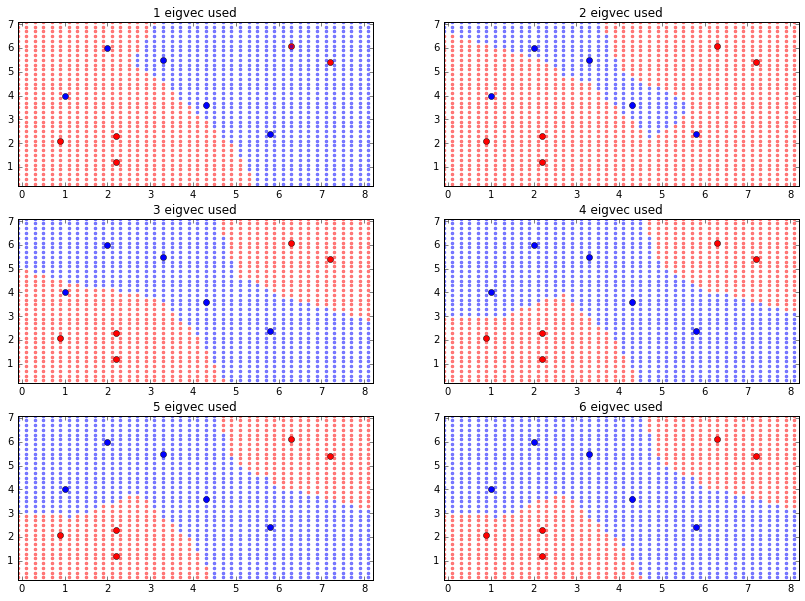

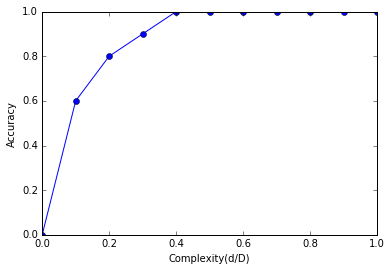

In [5]:
kPCA_analysis(A, Y, 0.1, [1,2,3,4,5,6], res = 0.2)

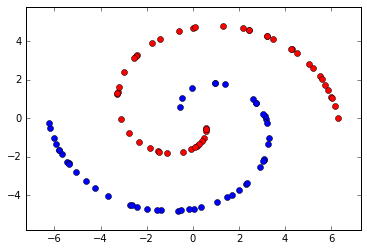

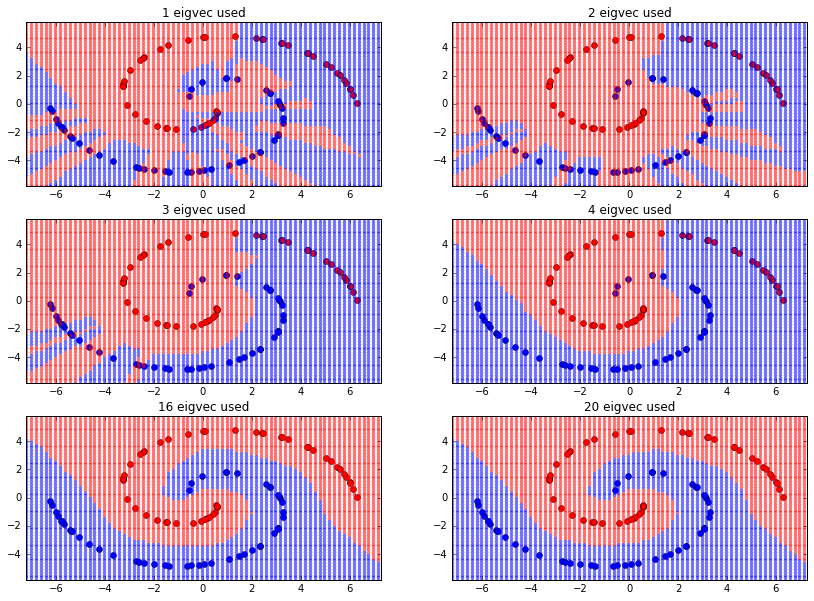

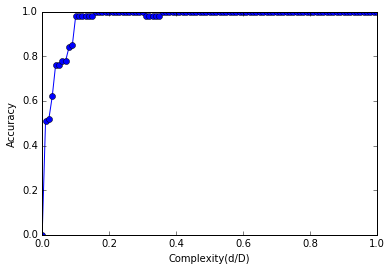

In [6]:
C, YC = spiral_data(100, 360, 0, 0)    
plot_data(C, YC)
kPCA_analysis(C, YC, 0.1, [1,2,3,4,16,20], 0.2)

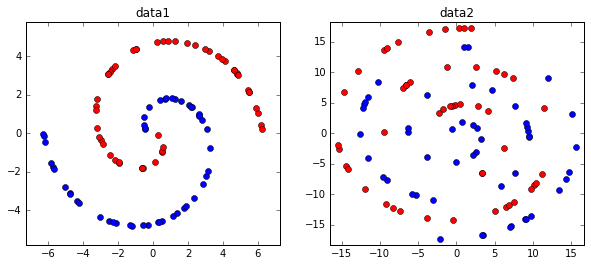

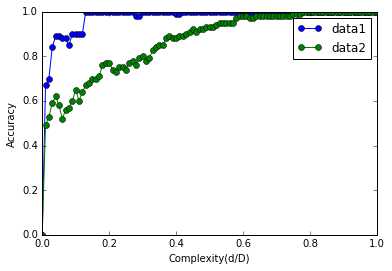

In [7]:
D, YD = spiral_data(100, 360, 0, 0)  
plt.figure(figsize=(10,4))
plt.subplot(1, 2, 1)
plot_data(D, YD)
plt.title('data1')
E, YE = spiral_data(100, 1000, 0, 0)  
plt.subplot(1, 2, 2)
plot_data(E, YE)
plt.title('data2')
plt.show()

kPCA_analysis(D, YD, 0.1, [], 0.5)
kPCA_analysis(E, YE, 0.1, [], 0.5)
plt.legend(['data1', 'data2'])
plt.show()